This script determines cell type specific genes based on McCarroll lab's adult mouse brain drop-seq data. 

In [168]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from matplotlib_venn import venn3

import heapq
import scipy.stats as stats

import statsmodels.api as sm
import matplotlib.ticker as mtick

from statannot import add_stat_annotation

import pingouin as pg

import plotly.express as px

matplotlib.rcParams['figure.dpi']= 300

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [170]:
annotation_df = pd.read_excel('../results/single-cell/saunders_2018/enhanced_annotation.xlsx',index_col='tissue_subcluster')

annotation_df.sort_index(axis=0,inplace=True)

In [173]:
# Getting the name of the clusters of different cell types;
# Will use later when comparing across cell types 
# cluster_dict={}
Neuron_cluster_list=[]
Vasculature_cluster_list=[]
Glia_cluster_list=[]
# Mitotic_cluster_list=[]
for index, row in annotation_df.iterrows():
    # cluster_dict[row['tissue_subcluster']]=row['master_class']
    if row['master_class']=='Neuron':
        Neuron_cluster_list.append(index)
    elif row['master_class']=='Vasculature':
        Vasculature_cluster_list.append(index)
    elif row['master_class']=='Glia':
        Glia_cluster_list.append(index)
    # elif row['master_class']=='Mitotic':
    #     Mitotic_cluster_list.append(row['tissue_subcluster'])

In [179]:
# Similarly, clusters belong to difference brain regions:
CB_cluster_list=[]
ENT_cluster_list=[]
FC_cluster_list=[]
GP_cluster_list=[]
HC_cluster_list=[]
PC_cluster_list=[]
SN_cluster_list=[]
STR_cluster_list=[]
TH_cluster_list=[]

for index, row in annotation_df.iterrows():
    if row['tissue']=='P60Cerebellum_ALT':
        CB_cluster_list.append(index)
    elif row['tissue']=='P60EntoPeduncular':
        ENT_cluster_list.append(index)
    elif row['tissue']=='P60Cortex_noRep5_FRONTALonly':
        FC_cluster_list.append(index)
    elif row['tissue']=='P60GlobusPallidus':
        GP_cluster_list.append(index)
    elif row['tissue']=='P60Hippocampus':
        HC_cluster_list.append(index)
    elif row['tissue']=='P60Cortex_noRep5_POSTERIORonly':
        PC_cluster_list.append(index)
    elif row['tissue']=='P60SubstantiaNigra':
        SN_cluster_list.append(index)
    elif row['tissue']=='P60Striatum':
        STR_cluster_list.append(index)
    elif row['tissue']=='P60Thalamus':
        TH_cluster_list.append(index)


In [172]:
# expression level in aggregated UMIs of each gene in each metacell
metacell_df = pd.read_csv('../data/single-cell/saunders_2018/metacells.BrainCellAtlas_Saunders_version_2018.04.01.csv', index_col=[0])

# metacell_df.sort_index(axis=1).equals(metacell_df) # False
# metacell_df.sort_index(axis=0).equals(metacell_df) # False
metacell_df.sort_index(axis=0,inplace=True)
metacell_df.sort_index(axis=1,inplace=True)

In [174]:
# metacell_sum_series = metacell_df.sum(axis=0)

# metacell_UMI_list = metacell_df.values.flatten().tolist()

# # Create a dataframe of expression by normalizing the aggregated UMI to total expression 
# norm_exp_df = metacell_df/metacell_sum_series

# num_cells_series = enhanced_annot_df.T.loc['num_cells',:]

# UMI normalized to number of cells in a cluster:

# norm_num_cells_df = metacell_df/num_cells_series

Total number of cells in neuronal, glial, and vasculature subclusters: 

In [188]:
print('Neuron:')
N_num=annotation_df.loc[Neuron_cluster_list,'num_cells'].sum()
print(N_num)

print('Glia:')
G_num=annotation_df.loc[Glia_cluster_list,'num_cells'].sum()
print(G_num)

print('Vasculature:')
V_num=annotation_df.loc[Vasculature_cluster_list,'num_cells'].sum()
print(V_num)

Neuron:
208630
Glia:
83888
Vasculature:
26824


Aggregated UMI, aka, total expression of all genes for each cell type:

In [205]:
print('Neuron:')
N_tot_exp = metacell_df[Neuron_cluster_list].to_numpy().sum()
print(N_tot_exp)

print('Glia:')
G_tot_exp = metacell_df[Glia_cluster_list].to_numpy().sum()
print(G_tot_exp)

print('Vasculature:')
V_tot_exp = metacell_df[Vasculature_cluster_list].to_numpy().sum()
print(V_tot_exp)

Neuron:
865551111
Glia:
183747735
Vasculature:
48591751


In [ ]:
master_class_df = pd.DataFrame()

master_class_df['UMI_per_Neuron']=metacell_df[Neuron_cluster_list].sum(axis=1)/N_num
master_class_df['UMI_per_Glial_Cell']=metacell_df[Glia_cluster_list].sum(axis=1)/G_num
master_class_df['UMI_per_Vasculature_Cell']=metacell_df[Vasculature_cluster_list].sum(axis=1)/V_num

master_class_df['UMI_per_Total_Neuronal_Expression']=metacell_df[Neuron_cluster_list].sum(axis=1)/N_tot_exp
master_class_df['UMI_per_Total_Glial_Expression']=metacell_df[Glia_cluster_list].sum(axis=1)/G_tot_exp
master_class_df['UMI_per_Total_Vasculature_Expression']=metacell_df[Vasculature_cluster_list].sum(axis=1)/V_tot_exp


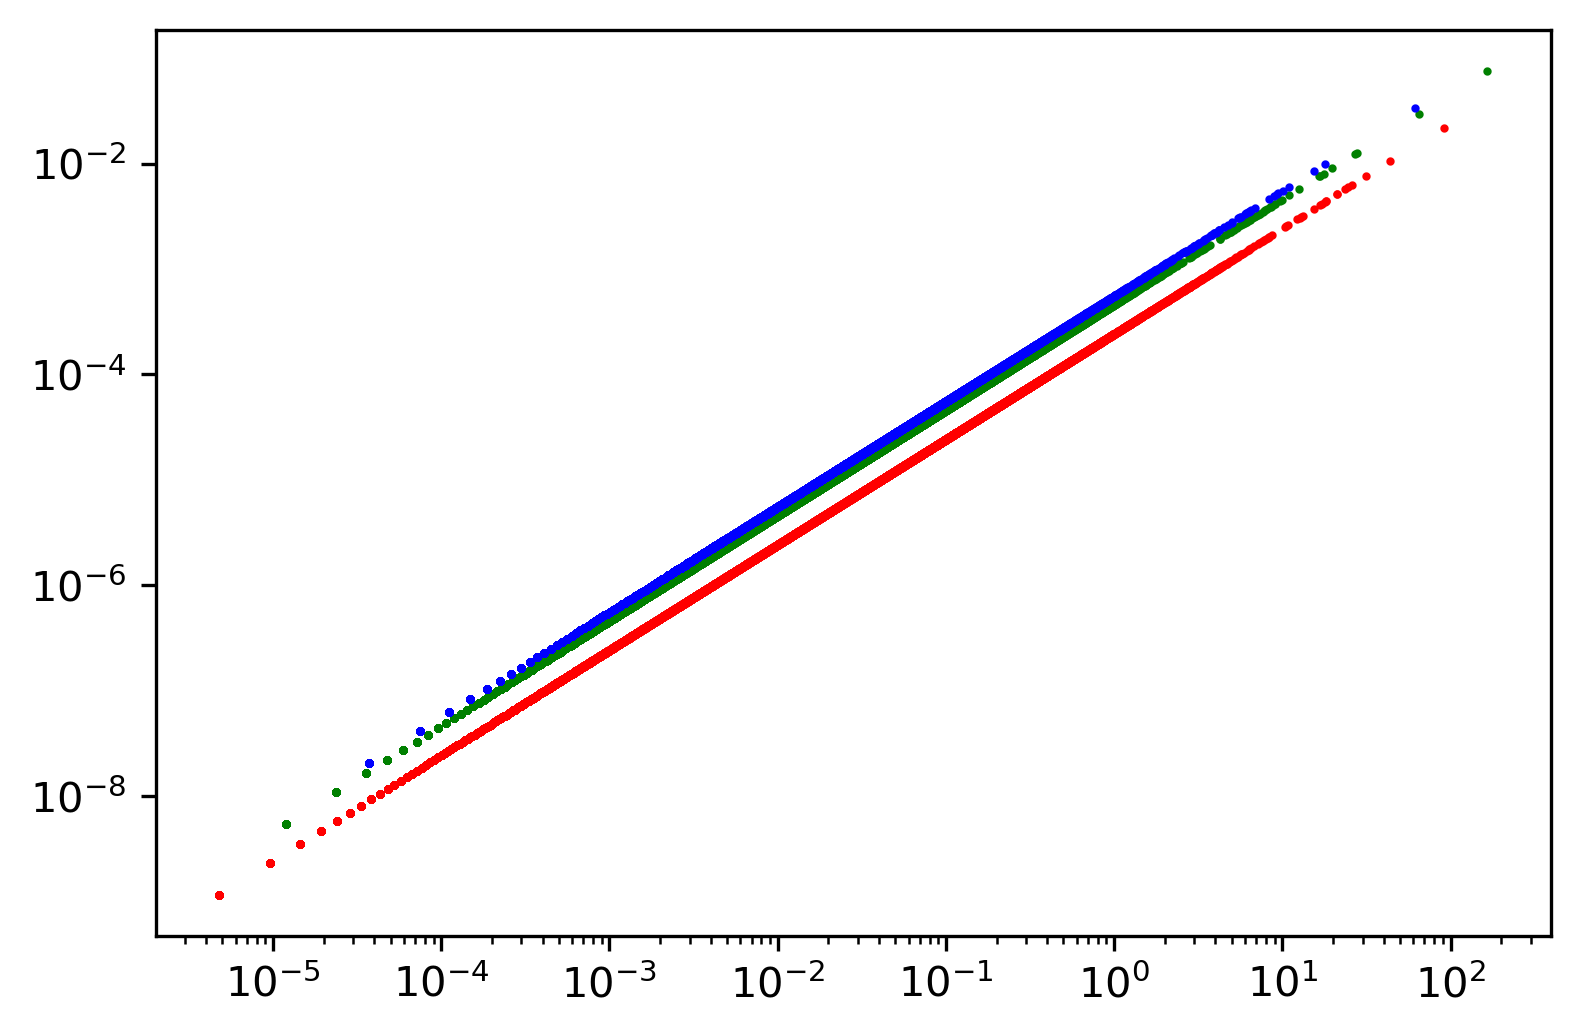

In [244]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')
ax.scatter(master_class_df['UMI_per_Neuron'],master_class_df['UMI_per_Total_Neuronal_Expression'],c='red',s=1)
ax.scatter(master_class_df['UMI_per_Glial_Cell'],master_class_df['UMI_per_Total_Glial_Expression'],c='green',s=1)
ax.scatter(master_class_df['UMI_per_Vasculature_Cell'],master_class_df['UMI_per_Total_Vasculature_Expression'],c='blue',s=1)


# ax1 = fig.add_subplot(311)
# ax2 = fig.add_subplot(312)
# ax3 = fig.add_subplot(313)
# sns.scatterplot(data=master_class_df,x='UMI_per_Neuron',y='UMI_per_Total_Neuronal_Expression',ax=ax1,palette=['red'])
# sns.scatterplot(data=master_class_df,x='UMI_per_Glial_Cell',y='UMI_per_Total_Glial_Expression',ax=ax2,palette=['green'])
# sns.scatterplot(data=master_class_df,x='UMI_per_Vasculature_Cell',y='UMI_per_Total_Vasculature_Expression',ax=ax3,palette=['blue'])

The difference is probably due to generally higher expression level of genes in neurons:

In [217]:
master_class_df['UMI_per_Total_Neuronal_Expression'].sum()
master_class_df['UMI_per_Total_Glial_Expression'].sum()
master_class_df['UMI_per_Total_Vasculature_Expression'].sum()

1.0

1.0

1.0

In [219]:
master_class_df['UMI_per_Neuron'].mean()
master_class_df['UMI_per_Glial_Cell'].mean()
master_class_df['UMI_per_Vasculature_Cell'].mean()

0.1284160562898496

0.06779934876223324

0.05607152617091126

In [240]:
# Number of genes with per cell UMI greater than 1: 
sum(i>1 for i in master_class_df['UMI_per_Neuron'].to_list())
sum(i>1 for i in master_class_df['UMI_per_Glial_Cell'].to_list())
sum(i>1 for i in master_class_df['UMI_per_Vasculature_Cell'].to_list())

767

228

207

(0.0, 10.0)

(0.0, 2500.0)

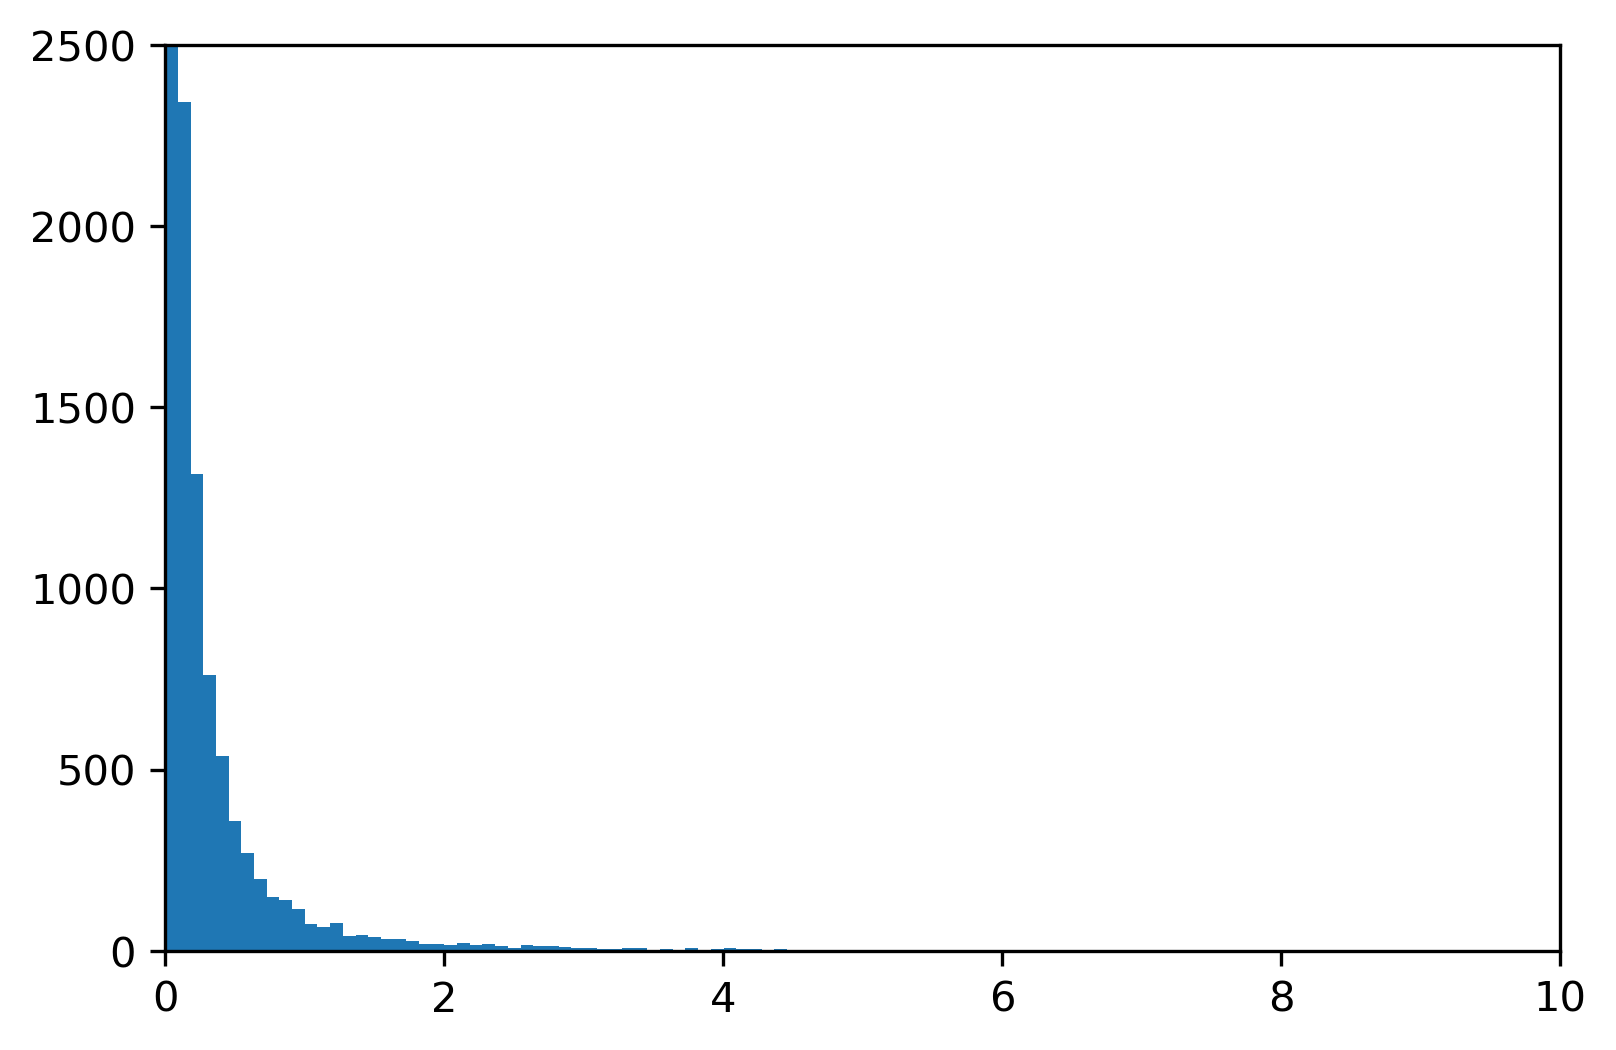

In [235]:
fig, ax = plt.subplots()
histogram = ax.hist(master_class_df['UMI_per_Neuron'],bins=1000)
plt.xlim([0,10])
plt.ylim([0,2500])
plt.show()

(0.0, 10.0)

(0.0, 2500.0)

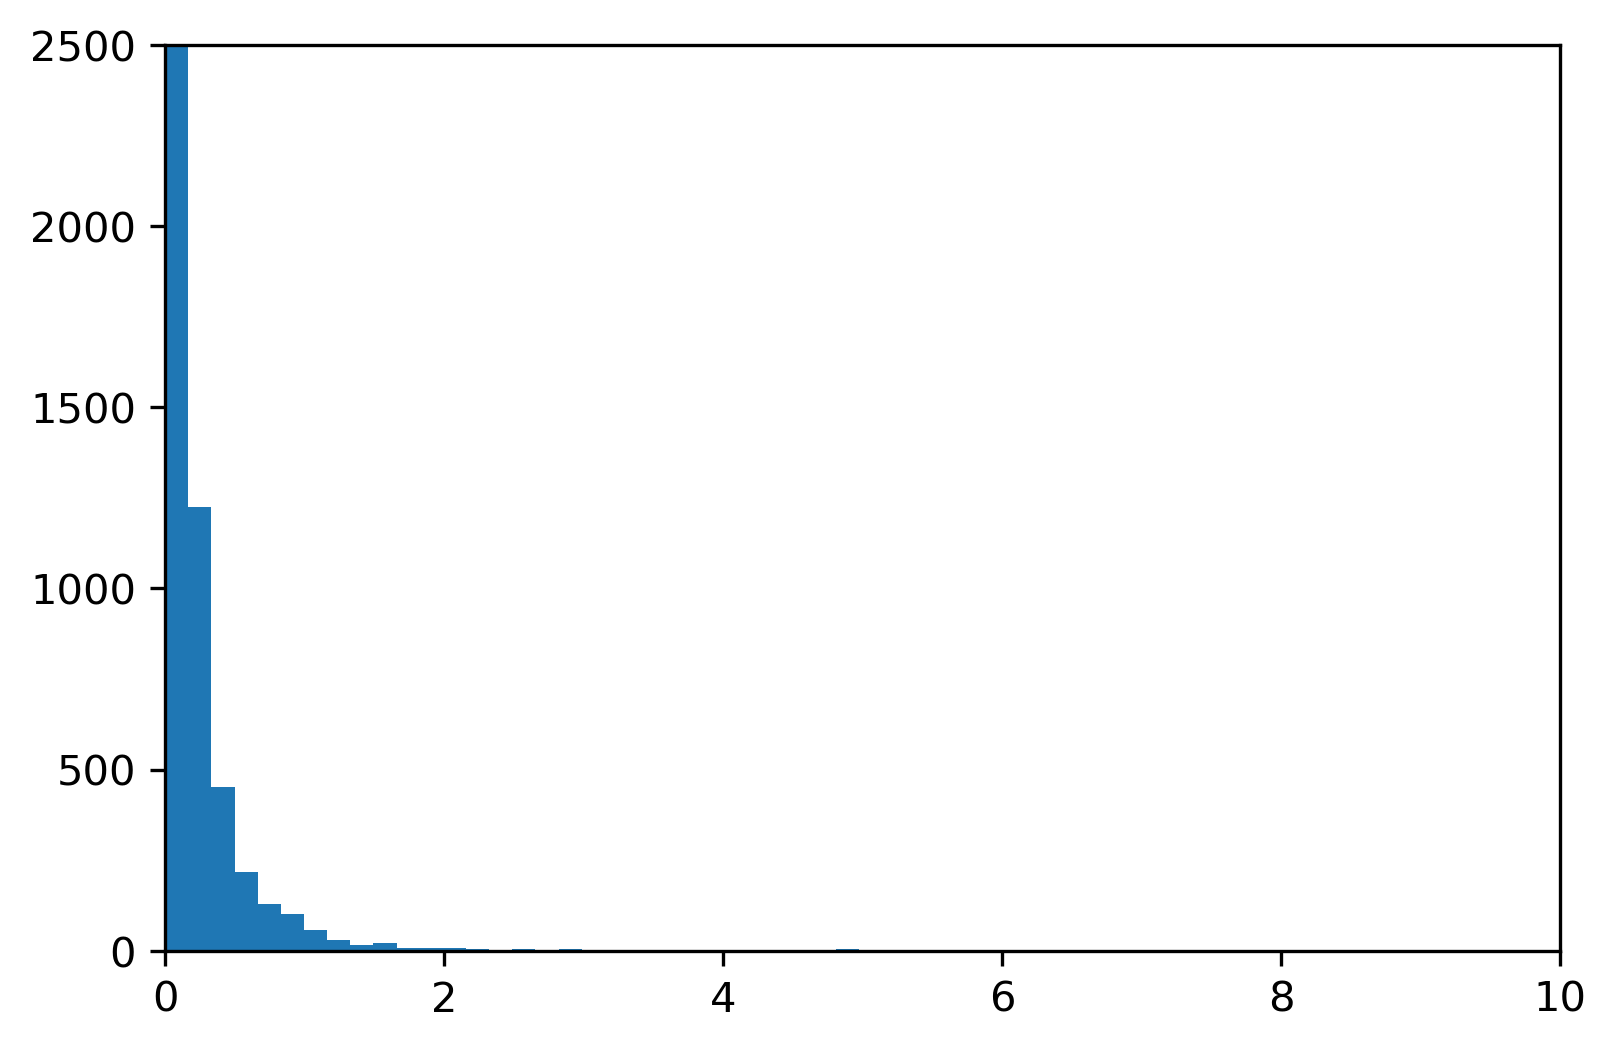

In [236]:
fig, ax = plt.subplots()
histogram = ax.hist(master_class_df['UMI_per_Glial_Cell'],bins=1000)
plt.xlim([0,10])
plt.ylim([0,2500])
plt.show()

(0.0, 10.0)

(0.0, 2500.0)

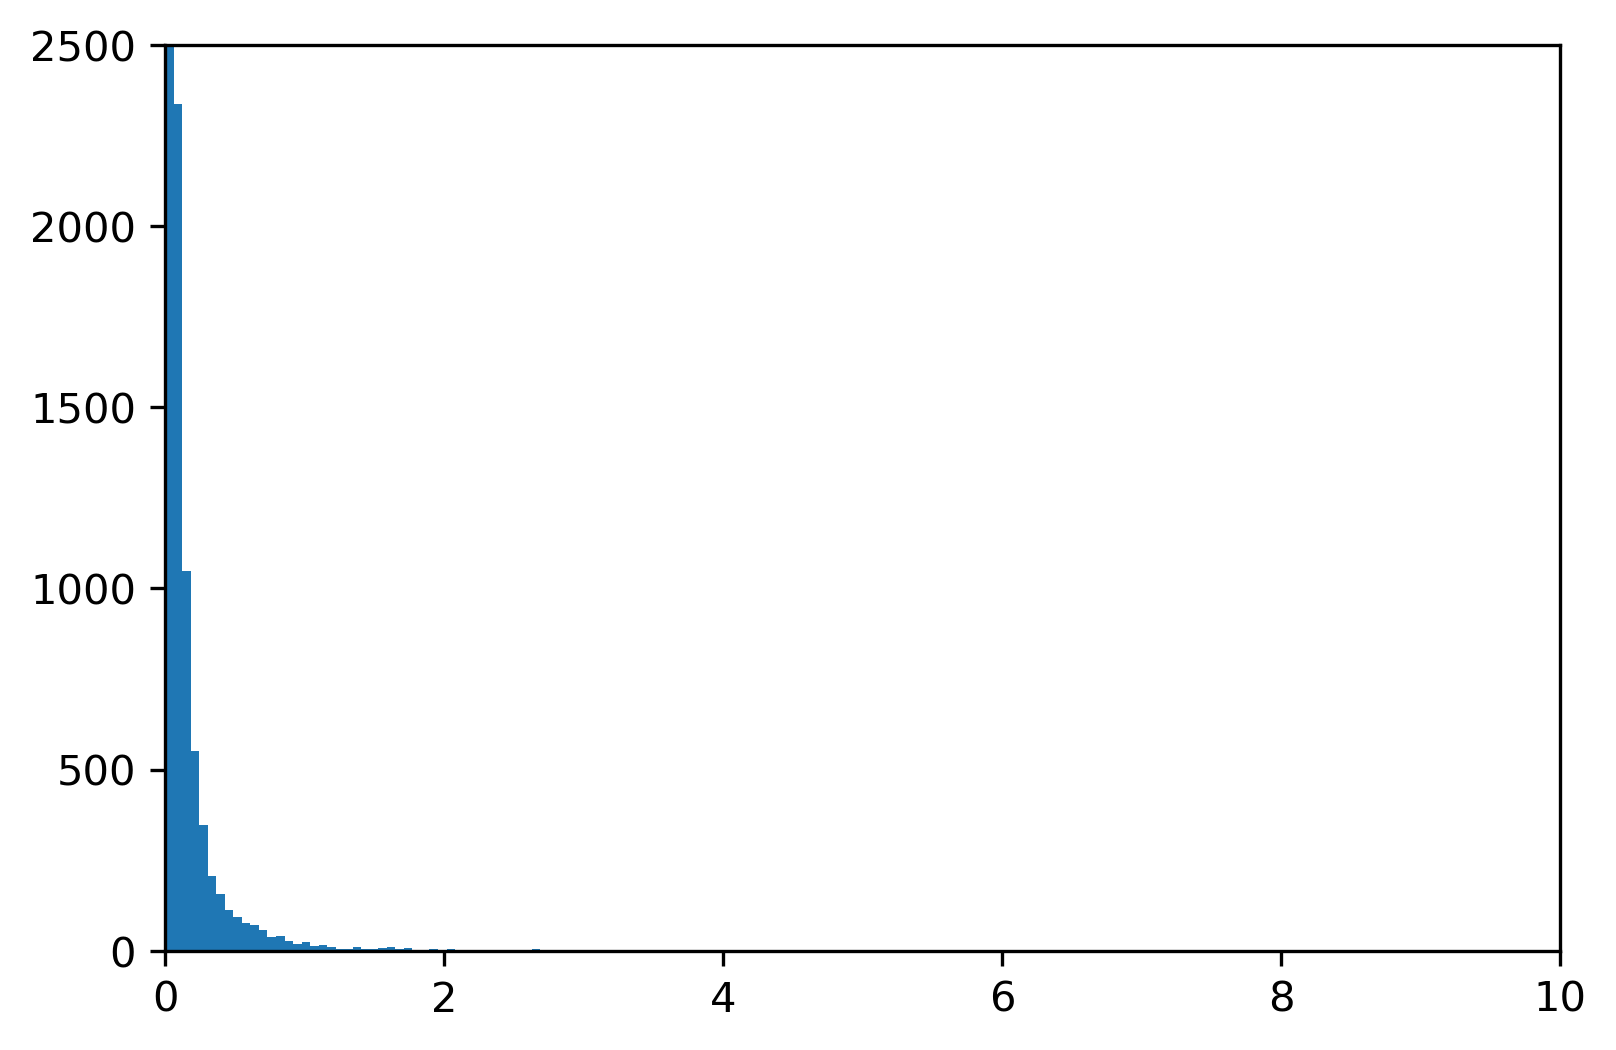

In [237]:
fig, ax = plt.subplots()
histogram = ax.hist(master_class_df['UMI_per_Vasculature_Cell'],bins=1000)
plt.xlim([0,10])
plt.ylim([0,2500])
plt.show()

# Define cell type-specific genes

### When normalizing to cell number

In [287]:
per_cell_master_class_df = master_class_df[['UMI_per_Neuron','UMI_per_Glial_Cell','UMI_per_Vasculature_Cell']].copy(deep=True)

per_cell_master_class_df.rename(columns={
    'UMI_per_Neuron':'N',
    'UMI_per_Glial_Cell':'G',
    'UMI_per_Vasculature_Cell':'V'}, inplace=True)

per_cell_master_class_df['Master_Class_Assignment']='NA'

df = per_cell_master_class_df
for i, row in df.iterrows():
    if ((row['N']>(row['G']+row['V'])*2) and (row['N']>1)):
        df.at[i,'Master_Class_Assignment']='N'
    elif ((row['G']>(row['N']+row['V'])*2) and (row['G']>1)):
        df.at[i,'Master_Class_Assignment']='G'
    elif ((row['V']>(row['G']+row['N'])*2) and (row['V']>1)):
        df.at[i,'Master_Class_Assignment']='V'

In [288]:
print("--- When normalizing UMI counts to cell number ---")
print("Number of Neuron-specific genes:")
df[df['Master_Class_Assignment']=='N'].shape[0]
print("Number of Glia-specific genes:")
df[df['Master_Class_Assignment']=='G'].shape[0]
print("Number of Vasculature-specific genes:")
df[df['Master_Class_Assignment']=='V'].shape[0]

--- When normalizing UMI counts to cell number ---
Number of Neuron-specific genes:


467

Number of Glia-specific genes:


91

Number of Vasculature-specific genes:


70

In [252]:
# fig = px.scatter_ternary(master_class_df, a='UMI_per_Neuron', b='UMI_per_Glial_Cell', c='UMI_per_Vasculature_Cell')
# fig.show()

Decided not to normalize to cell number but to total expression instead.

### When normalizing with total expression

In [295]:
per_exp_master_class_df = master_class_df[['UMI_per_Total_Neuronal_Expression',
                                           'UMI_per_Total_Glial_Expression',
                                           'UMI_per_Total_Vasculature_Expression']].copy(deep=True)

per_exp_master_class_df.rename(columns={
    'UMI_per_Total_Neuronal_Expression':'N',
    'UMI_per_Total_Glial_Expression':'G',
    'UMI_per_Total_Vasculature_Expression':'V'}, inplace=True)

per_exp_master_class_df['Master_Class_Assignment']='NA'

df = per_exp_master_class_df
for i, row in df.iterrows():
    if ((row['N']>(row['G']+row['V'])*2) and (row['N']>0.0001)):
        df.at[i,'Master_Class_Assignment']='N'
    elif ((row['G']>(row['N']+row['V'])*2) and (row['G']>0.0001)):
        df.at[i,'Master_Class_Assignment']='G'
    elif ((row['V']>(row['G']+row['N'])*2) and (row['V']>0.0001)):
        df.at[i,'Master_Class_Assignment']='V'

In [296]:
print("--- When normalizing UMI counts to total expression ---")
print("Number of Neuron-specific genes:")
df[df['Master_Class_Assignment']=='N'].shape[0]
print("Number of Glia-specific genes:")
df[df['Master_Class_Assignment']=='G'].shape[0]
print("Number of Vasculature-specific genes:")
df[df['Master_Class_Assignment']=='V'].shape[0]

--- When normalizing UMI counts to total expression ---
Number of Neuron-specific genes:


699

Number of Glia-specific genes:


322

Number of Vasculature-specific genes:


453

In [151]:
# norm_exp_df['Neuron_mean']=norm_exp_df[Neuron_cluster_list].mean(axis=1)
# norm_exp_df['Vasculature_mean']=norm_exp_df[Vasculature_cluster_list].mean(axis=1)
# norm_exp_df['Glia_mean']=norm_exp_df[Glia_cluster_list].mean(axis=1)

# norm_exp_df['Neuron_min']=norm_exp_df[Neuron_cluster_list].min(axis=1)
# norm_exp_df['Glia_min']=norm_exp_df[Glia_cluster_list].min(axis=1)
# norm_exp_df['Vasculature_min']=norm_exp_df[Vasculature_cluster_list].min(axis=1)

# # Genes with non-zero expression in all clusters that belong to a cell type
# print('Number of genes universally expressed in cell type:')
# # number of genes universally expressed in neuron clusters
# print('neuron:')
# norm_exp_df[norm_exp_df['Neuron_min']!=0].shape[0]
# # number of genes universally expressed in glia clusters
# print('glia:')
# norm_exp_df[norm_exp_df['Glia_min']!=0].shape[0]
# # number of genes universally expressed in vasculature clusters
# print('vasculature:')
# norm_exp_df[norm_exp_df['Vasculature_min']!=0].shape[0]

In [120]:
# # Define neuron-, glia-, and vasculature-expressed genes as genes with more than 10M average UMIs
# metacell_df['Neuron-expressed']=0
# metacell_df['Glia-expressed']=0
# metacell_df['Vasculature-expressed']=0
# metacell_df.loc[metacell_df.Neuron_mean>=,'Neuron-expressed']=1
# metacell_df.loc[metacell_df.Glia_mean>=100,'Glia-expressed']=1
# metacell_df.loc[metacell_df.Vasculature_mean>=100,'Vasculature-expressed']=1

# metacell_df[metacell_df['Neuron-expressed']==1].shape
# metacell_df[metacell_df['Glia-expressed']==1].shape
# metacell_df[metacell_df['Vasculature-expressed']==1].shape

# # Genes with expression greater or equal to 100k in all cluster of that master class
# # AND with expression greater than 10M when averaged across all cluster of that master class
# metacell_df['Neuron-expressed-universal']=0
# metacell_df['Glia-expressed-universal']=0
# metacell_df['Vasculature-expressed-universal']=0

# metacell_df.loc[(metacell_df['Vasculature_min']>0)&(metacell_df['Vasculature_mean']>=100),'Vasculature-expressed-universal']=1
# metacell_df.loc[(metacell_df['Neuron_min']>0)&(metacell_df['Neuron_mean']>=100),'Neuron-expressed-universal']=1
# metacell_df.loc[(metacell_df['Glia_min']>0)&(metacell_df['Glia_mean']>=100),'Glia-expressed-universal']=1

# metacell_df[metacell_df['Neuron-expressed-universal']==1].shape
# metacell_df[metacell_df['Glia-expressed-universal']==1].shape
# metacell_df[metacell_df['Vasculature-expressed-universal']==1].shape

In [138]:
# N_set = set(metacell_df[metacell_df['Neuron-expressed']==1].index)
# G_set = set(metacell_df[metacell_df['Glia-expressed']==1].index)
# V_set = set(metacell_df[metacell_df['Vasculature-expressed']==1].index)

# venn3([N_set,G_set,V_set],set_labels=('Neuron','Glia','Vasculature'))

In [136]:
# NU_set = set(metacell_df[metacell_df['Neuron-expressed-universal']==1].index)
# GU_set = set(metacell_df[metacell_df['Glia-expressed-universal']==1].index)
# VU_set = set(metacell_df[metacell_df['Vasculature-expressed-universal']==1].index)

# venn3([NU_set,GU_set,VU_set],set_labels=('Neuron','Glia','Vasculature'))

In [153]:
# # Define neuron-, glia-, and vasculature-specific genes
# metacell_df['Neuron-specific']=0
# metacell_df['Glia-specific']=0
# metacell_df['Vasculature-specific']=0
# NS_set=NU_set&(NU_set^GU_set)&(NU_set^VU_set)
# GS_set=GU_set&(GU_set^NU_set)&(GU_set^VU_set)
# VS_set=VU_set&(VU_set^NU_set)&(VU_set^GU_set)
# metacell_df.loc[list(NS_set),'Neuron-specific']=1
# metacell_df.loc[list(GS_set),'Glia-specific']=1
# metacell_df.loc[list(VS_set),'Vasculature-specific']=1

# metacell_df[metacell_df["Neuron-specific"]==1].shape
# metacell_df[metacell_df["Glia-specific"]==1].shape
# metacell_df[metacell_df["Vasculature-specific"]==1].shape

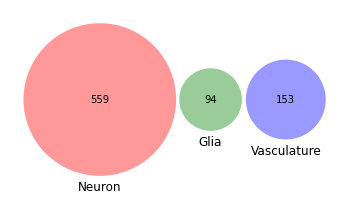

In [154]:
# venn3([NS_set,GS_set,VS_set],set_labels=('Neuron','Glia','Vasculature'))

# Analyzing the dN/dS of cell type-specific genes

In [299]:
avg_dNdS_df=pd.read_csv('../results/Ensembl98_mouse/mouse.dNdS_stats.all_genes.tsv',sep='\t',usecols=['Gene name','mean'],index_col='Gene name')

avg_dNdS_df.rename(columns={'mean':'avg_dNdS'},inplace=True)

In [302]:
merge_df=pd.merge(left=per_exp_master_class_df,right=avg_dNdS_df,left_index=True,right_index=True,how="inner")

In [304]:
merge_df[merge_df['Master_Class_Assignment']=='N'].shape
merge_df[merge_df['Master_Class_Assignment']=='G'].shape
merge_df[merge_df['Master_Class_Assignment']=='V'].shape

(673, 5)

(304, 5)

(430, 5)

In [307]:
N_arr=merge_df[merge_df['Master_Class_Assignment']=='N']['avg_dNdS'].dropna().values
G_arr=merge_df[merge_df['Master_Class_Assignment']=='G']['avg_dNdS'].dropna().values
V_arr=merge_df[merge_df['Master_Class_Assignment']=='V']['avg_dNdS'].dropna().values

Text(0.5, 0.98, 'Distribution of dN/dS of Mouse Cell Type-specific Genes Based on Saunders et al 2018')

Text(0.5, 0, 'dN/dS')

Text(0, 0.5, 'number of genes')

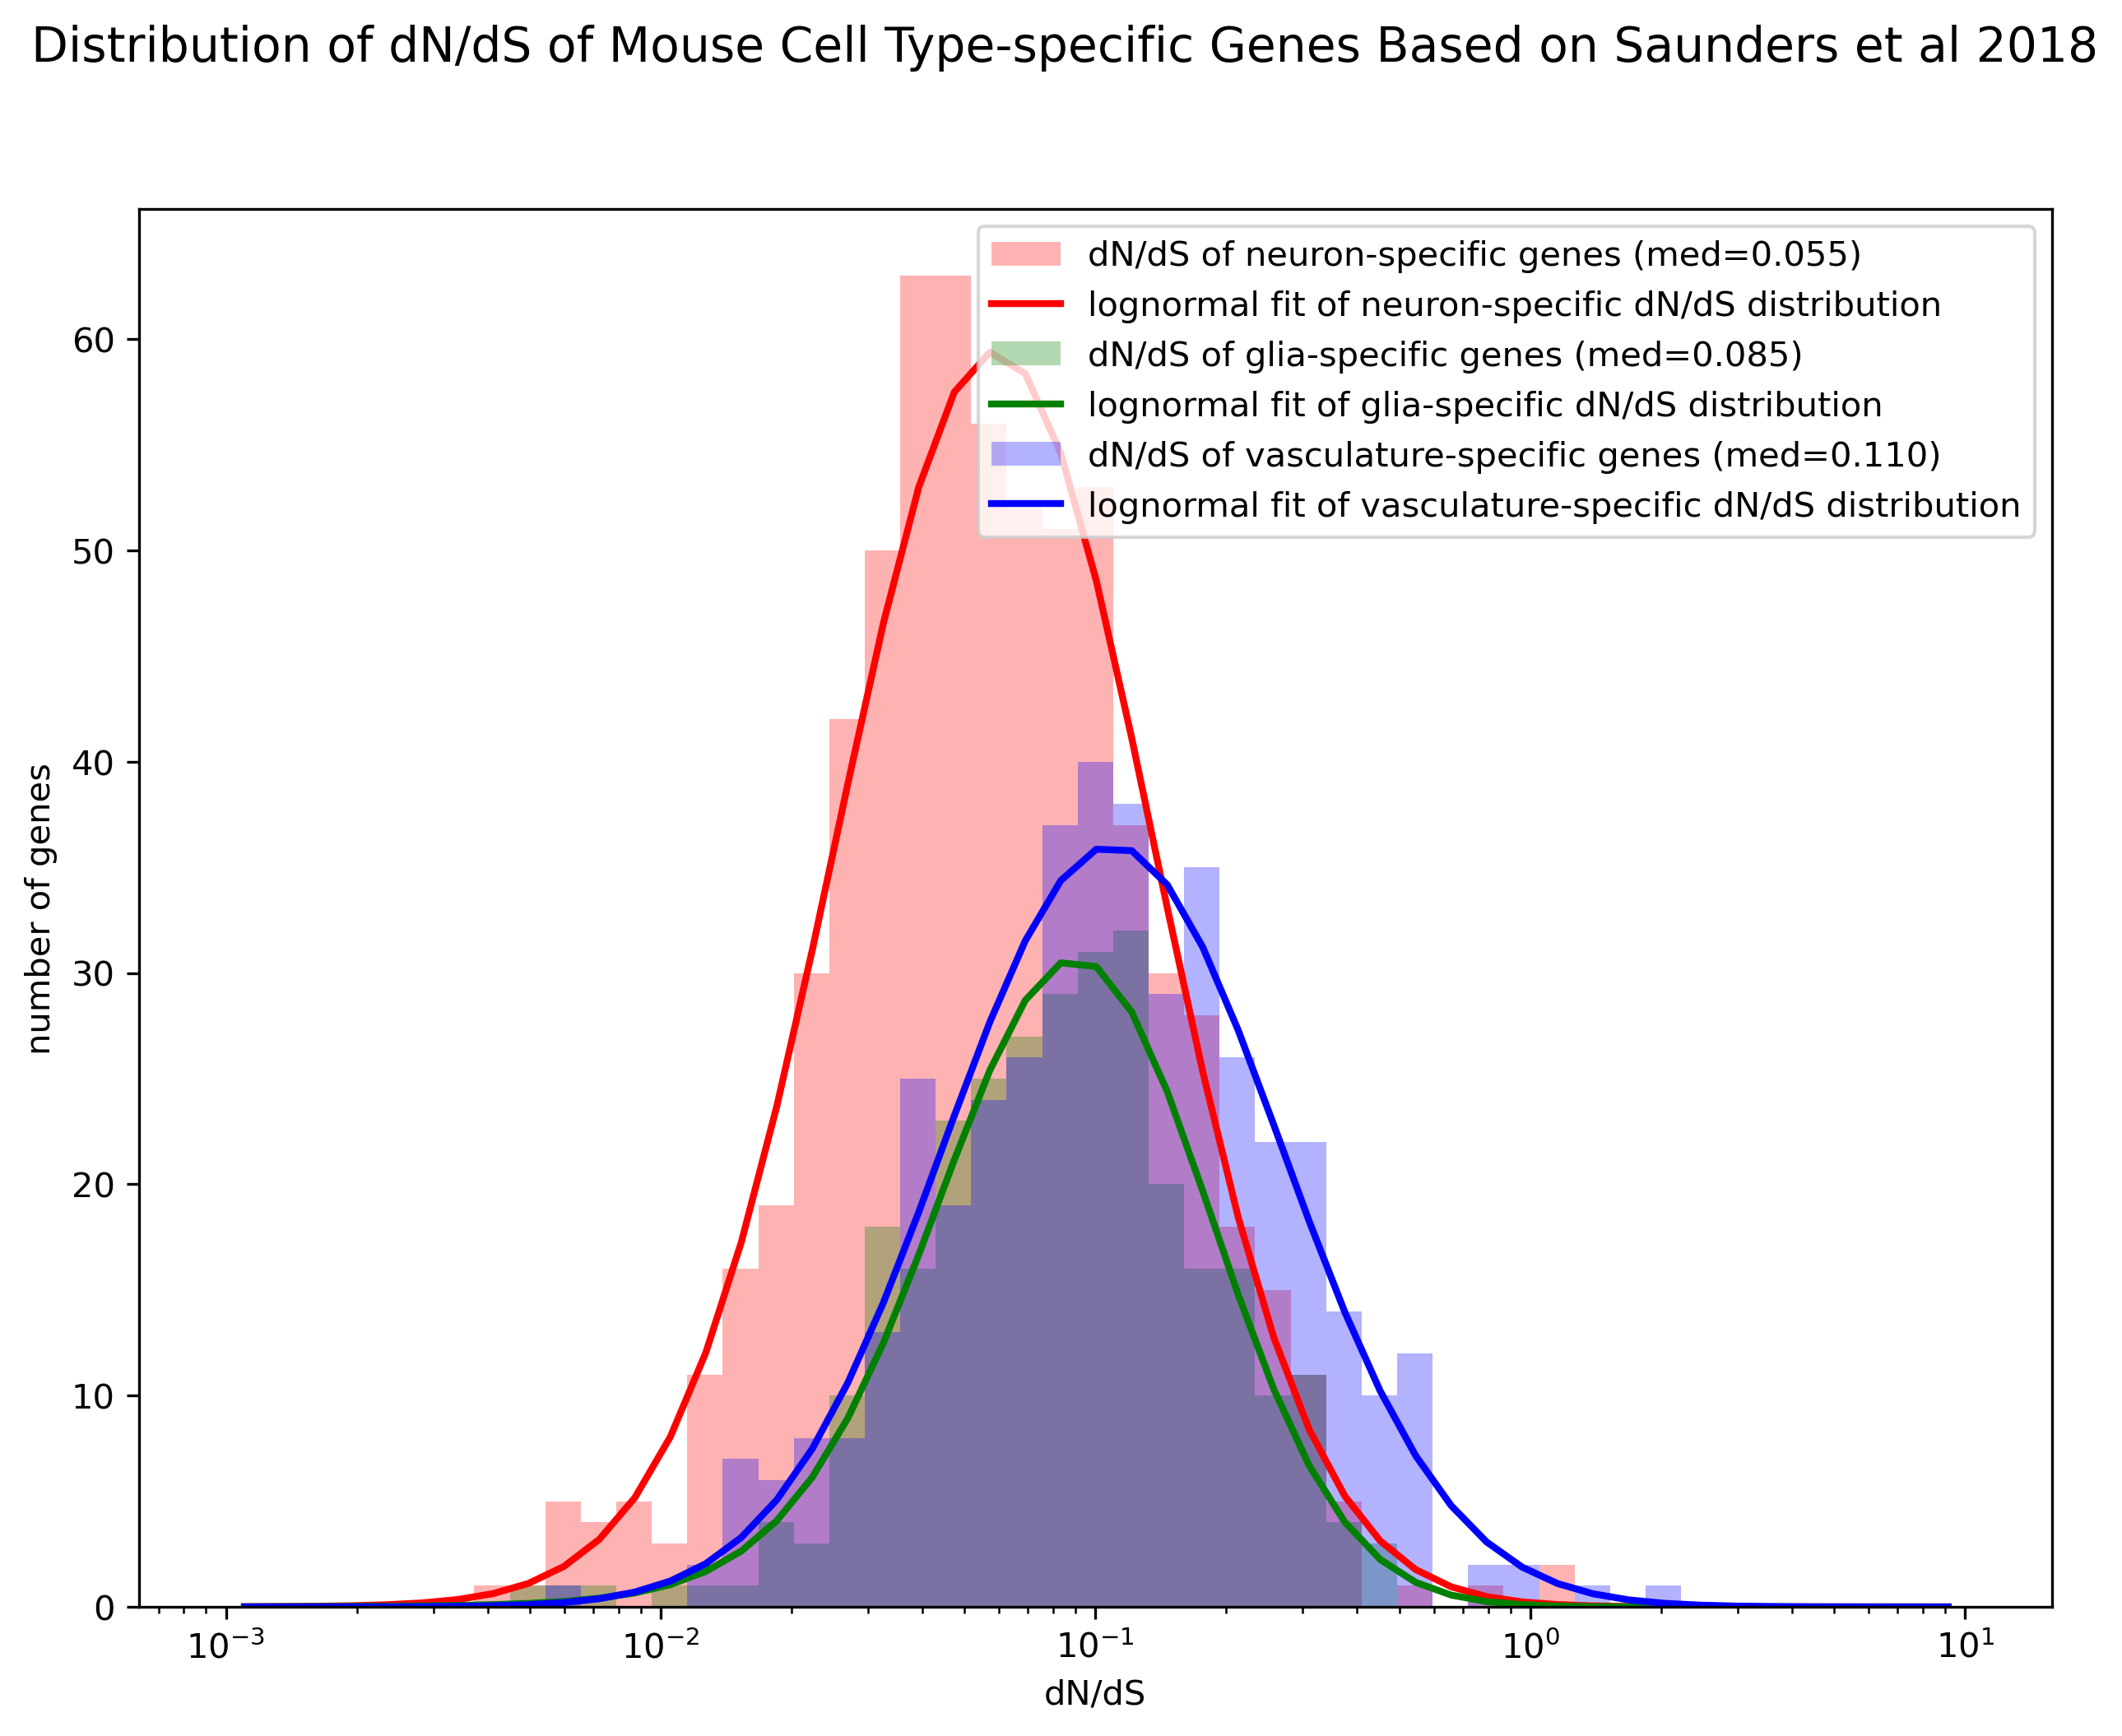

In [308]:
# Creating a figure 
fig = plt.figure(figsize=(10,7.5)) # Size of a letter size paper in horizontal
fig.suptitle('Distribution of dN/dS of Mouse Cell Type-specific Genes Based on Saunders et al 2018', fontsize=14)

# Setting subplot space
grid = plt.GridSpec(nrows=1,ncols=1)
#grid.update(wspace=0.5, hspace=0.3)

# The subplot for distribution histogram 
distr_plot = fig.add_subplot(grid[:,:])
#distr_hist = dist_GO_df.plot(ax=distr_plot, kind='hist',alpha=0.3,bins=np.logspace(np.log10(0.001),np.log10(10), 100), logx=True, color=['royalblue','orange','lightgreen'])

# Set up the bins for log scale x-axis, and get the centers
bins=np.logspace(np.log10(0.001),np.log10(10), 50)
bins_cntr = (bins[1:] + bins[:-1]) / 2

# Neuron-specific genes' dN/dS histogram and curve
N_counts, N_bin_edges, ignored = distr_plot.hist(N_arr,bins,histtype='stepfilled',alpha=0.3,color='red',label='dN/dS of neuron-specific genes (med={0:.3f})'.format(np.median(N_arr)))
try:
    # calculate area of histograms (area under PDF should be 1)
    N_area_hist = ((N_bin_edges[1:] - N_bin_edges[:-1]) * N_counts).sum()
    N_shape, N_loc, N_scale = stats.lognorm.fit(N_arr)
    # pdf-values using cdf 
    N_fit_log_cntr_ = stats.lognorm.cdf(bins, N_shape, loc=N_loc, scale=N_scale)
    N_fit_log_cntr = np.diff(N_fit_log_cntr_)
    # plot fitted and scaled PDFs into histogram
    distr_plot.plot(bins_cntr, N_fit_log_cntr * N_counts.sum(),'r-', 
                    label='lognormal fit of neuron-specific dN/dS distribution', linewidth=2)
except ValueError:
    pass

# Glia-specific genes' dN/dS histogram and curve
G_counts, G_bin_edges, ignored = distr_plot.hist(G_arr,bins,histtype='stepfilled',alpha=0.3,color='green',label='dN/dS of glia-specific genes (med={0:.3f})'.format(np.median(G_arr)))
try:
    # calculate area of histograms (area under PDF should be 1)
    G_area_hist = ((G_bin_edges[1:] - G_bin_edges[:-1]) * G_counts).sum()
    G_shape, G_loc, G_scale = stats.lognorm.fit(G_arr)
    # pdf-values using cdf 
    G_fit_log_cntr_ = stats.lognorm.cdf(bins, G_shape, loc=G_loc, scale=G_scale)
    G_fit_log_cntr = np.diff(G_fit_log_cntr_)
    # plot fitted and scaled PDFs into histogram
    distr_plot.plot(bins_cntr, G_fit_log_cntr * G_counts.sum(),'g-', 
                    label='lognormal fit of glia-specific dN/dS distribution', linewidth=2)
except ValueError:
    pass


# Vasculature-specific genes' dN/dS histogram and curve
V_counts, V_bin_edges, ignored = distr_plot.hist(V_arr,bins,histtype='stepfilled',alpha=0.3,color='blue',label='dN/dS of vasculature-specific genes (med={0:.3f})'.format(np.median(V_arr)))
try:
    # calculate area of histograms (area under PDF should be 1)
    V_area_hist = ((V_bin_edges[1:] - V_bin_edges[:-1]) * V_counts).sum()
    V_shape, V_loc, V_scale = stats.lognorm.fit(V_arr)
    # pdf-values using cdf 
    V_fit_log_cntr_ = stats.lognorm.cdf(bins, V_shape, loc=V_loc, scale=V_scale)
    V_fit_log_cntr = np.diff(V_fit_log_cntr_)
    # plot fitted and scaled PDFs into histogram
    distr_plot.plot(bins_cntr, V_fit_log_cntr * V_counts.sum(),'b-', 
                    label='lognormal fit of vasculature-specific dN/dS distribution', linewidth=2)
except ValueError:
    pass

# Axis labels
distr_plot.set_xlabel(xlabel='dN/dS')
distr_plot.set_ylabel(ylabel='number of genes')
distr_plot.set_xscale('log')
distr_plot.legend(loc='best')
# distr_plot.yaxis.set_major_formatter(mtick.PercentFormatter(1))

# fig.savefig('../figures/mouse.organs.pdf')
# fig.savefig('../figures/mouse.organs.eps')
# fig.savefig('../figures/mouse.organs.png')
# plt.close()

In [351]:
pg.mwu(G_arr,N_arr,alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,129559.0,two-sided,2.448778e-11,-0.266511,0.633255


In [352]:
pg.mwu(V_arr,N_arr,alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,201828.0,two-sided,1.704840e-28,-0.394851,0.697426


In [353]:
pg.mwu(V_arr,G_arr,alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,76620.0,two-sided,0.000069,-0.172277,0.586138


# Check distribution of UMIs. Do Not need to rerun. 

In [ ]:
metacell_df['mean']=metacell_to_listan(axis=1)

metacell_df['Neuron_mean']=metacell_df[Neuron_cluster_list].mean(axis=1)
metacell_df['Vasculature_mean']=metacell_df[Vasculature_cluster_list].mean(axis=1)
metacell_df['Glia_mean']=metacell_df[Glia_cluster_list].mean(axis=1)
metacell_df['Mitotic_mean']=metacell_df[Mitotic_cluster_list].mean(axis=1)

metacell_df['Neuron_std']=metacell_df[Neuron_cluster_list].std(axis=1)
metacell_df['Glia_std']=metacell_df[Glia_cluster_list].std(axis=1)
metacell_df['Vasculature_std']=metacell_df[Vasculature_cluster_list].std(axis=1)

metacell_df['Neuron_min']=metacell_df[Neuron_cluster_list].min(axis=1)
metacell_df['Glia_min']=metacell_df[Glia_cluster_list].min(axis=1)
metacell_df['Vasculature_min']=metacell_df[Vasculature_cluster_list].min(axis=1)

metacell_df[metacell_df['mean']>0].shape
# There are 32307-31309=998 genes with no detectable expression

In [ ]:
non_zero_UMI_list=[i for i in metacell_UMI_list if i != 0]

In [ ]:
min(non_zero_UMI_list)

1

In [ ]:
len(non_zero_UMI_list)

7277937

[None]

<AxesSubplot:ylabel='Count'>

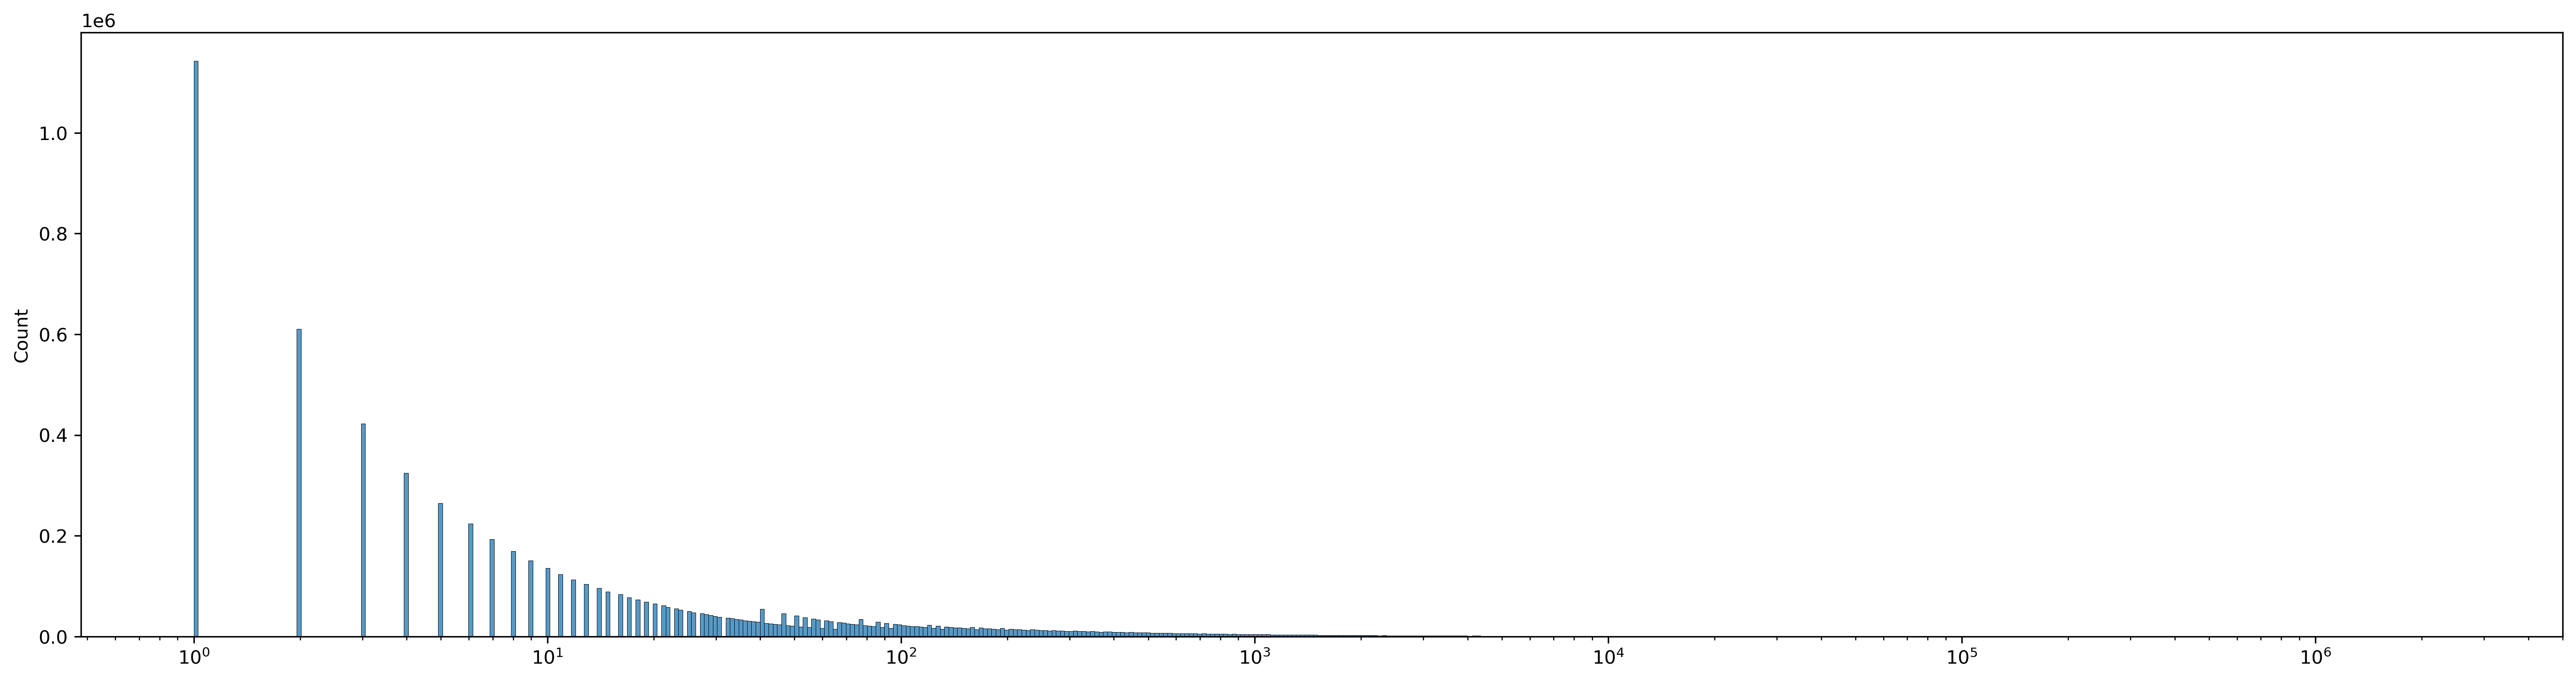

In [219]:
fig, ax = plt.subplots(figsize=(24,6))
ax.set(xscale="log")
sns.histplot(non_zero_UMI_list,ax=ax)
# plt.xlim([0, 100000])

/var/folders/_g/l621c6655y96l4zm2nwpfyq00000gn/T/ipykernel_14614/2546146506.py:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 50000])


(0.0007536017362068288, 50000)

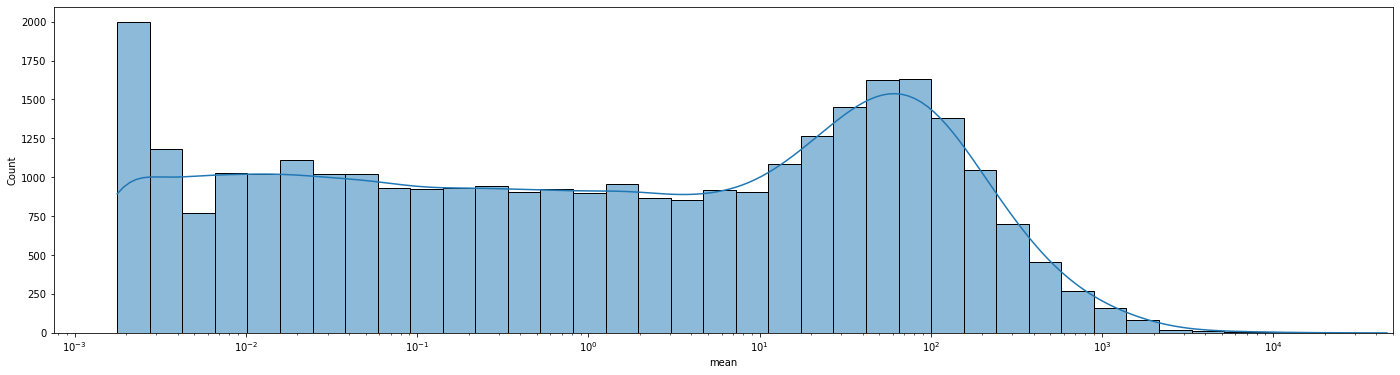

In [28]:
df=metacell_df[metacell_df['mean']>0]
fig, ax = plt.subplots(figsize=(24,6))
ax.set(xscale="log")
sns.histplot(ax=ax,data=df,x='mean', kde=True)
plt.xlim([0, 50000])

/var/folders/_g/l621c6655y96l4zm2nwpfyq00000gn/T/ipykernel_14614/3566739292.py:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 50000])


(0.0012874968030502302, 50000)

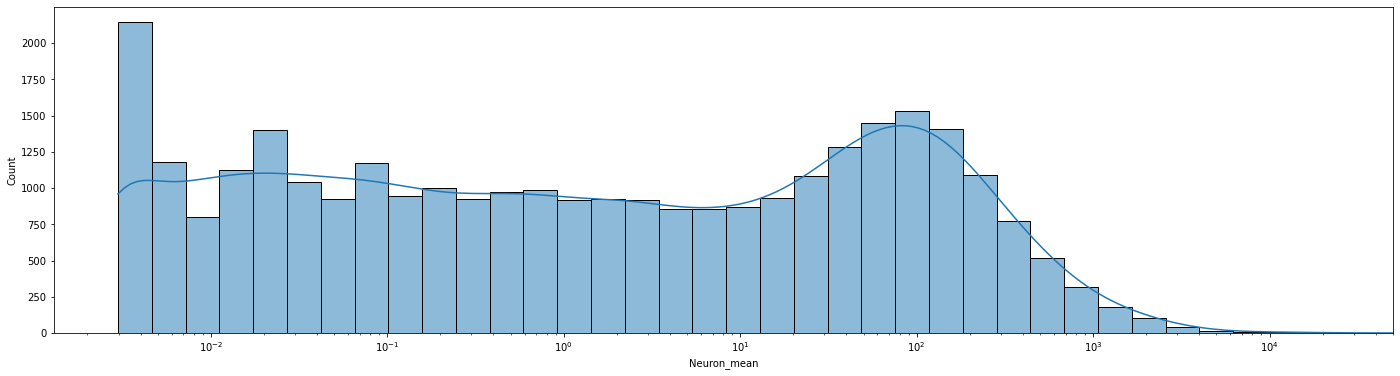

In [35]:
df=metacell_df[metacell_df['Neuron_mean']>0]
fig, ax = plt.subplots(figsize=(24,6))
ax.set(xscale="log")
sns.histplot(ax=ax,data=df,x='Neuron_mean', kde=True)
plt.xlim([0, 50000])

[None]

<AxesSubplot:xlabel='Neuron_mean', ylabel='Count'>

/var/folders/_g/l621c6655y96l4zm2nwpfyq00000gn/T/ipykernel_1815/2624655183.py:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 1])


(1.4273396144314964e-11, 1)

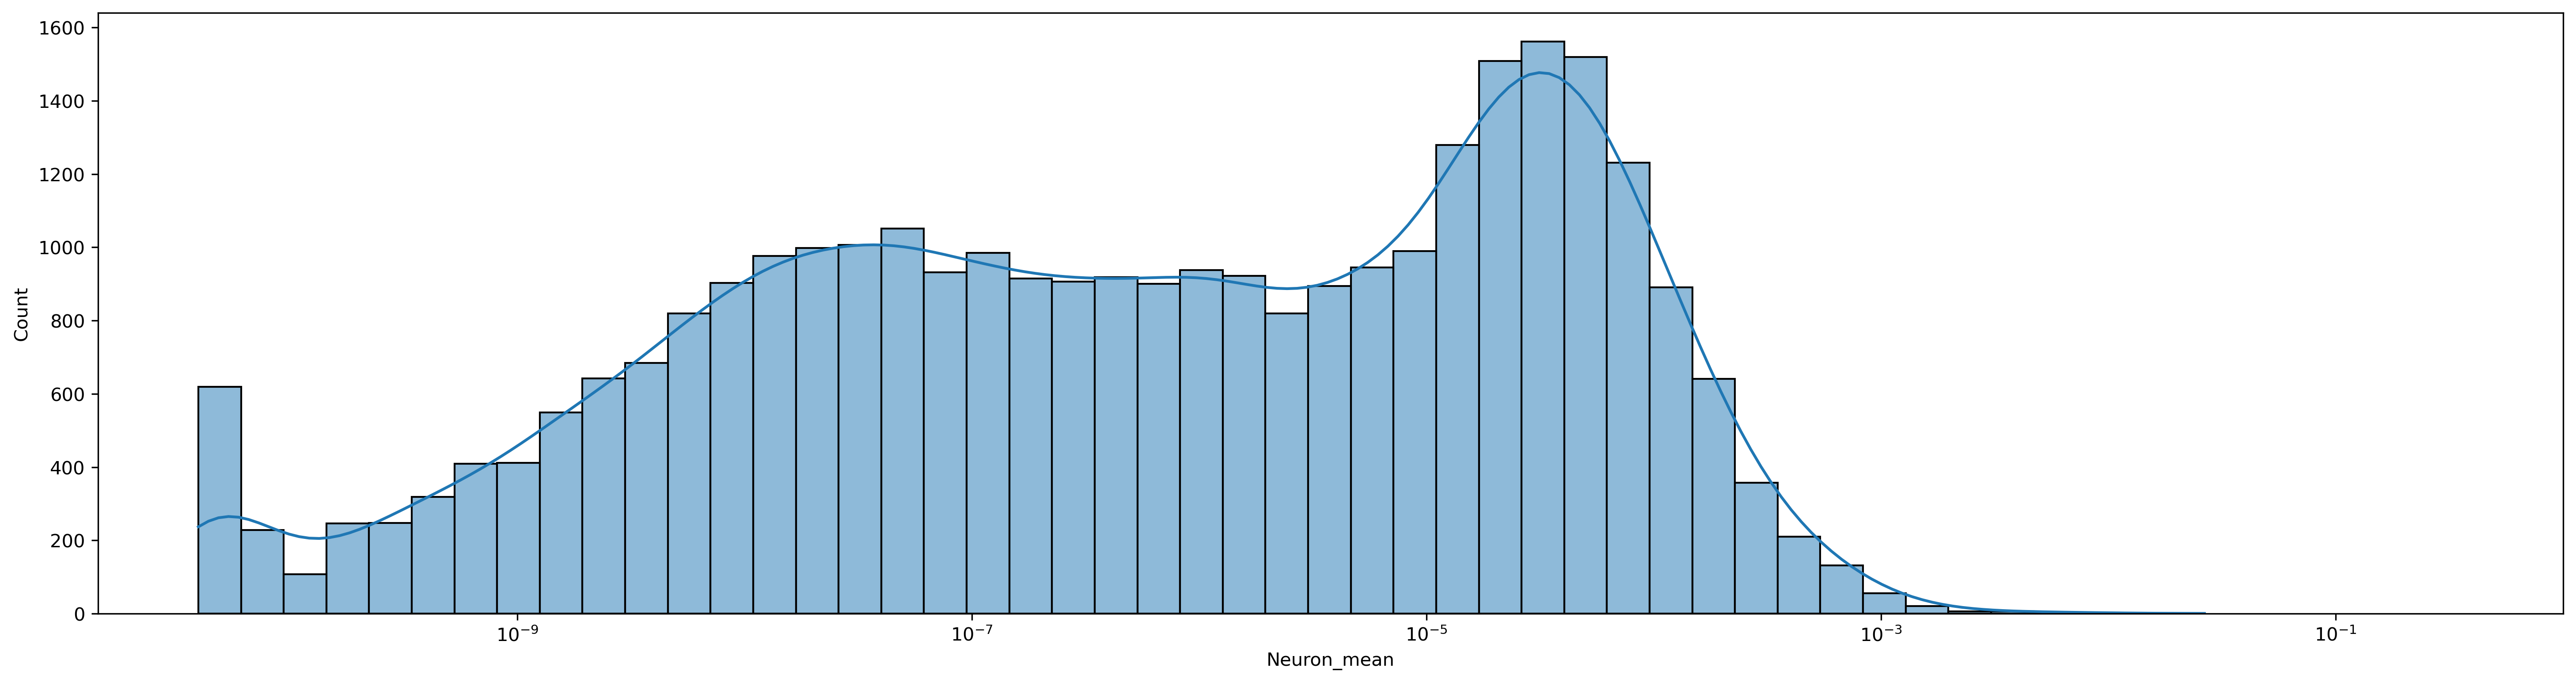

In [128]:
df=norm_exp_df[norm_exp_df['Neuron_mean']>0]
fig, ax = plt.subplots(figsize=(24,6))
ax.set(xscale="log")
sns.histplot(ax=ax,data=df,x='Neuron_mean', kde=True)
plt.xlim([0, 1])

/var/folders/_g/l621c6655y96l4zm2nwpfyq00000gn/T/ipykernel_14614/3855273330.py:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 50000])


(0.004656683052336018, 50000)

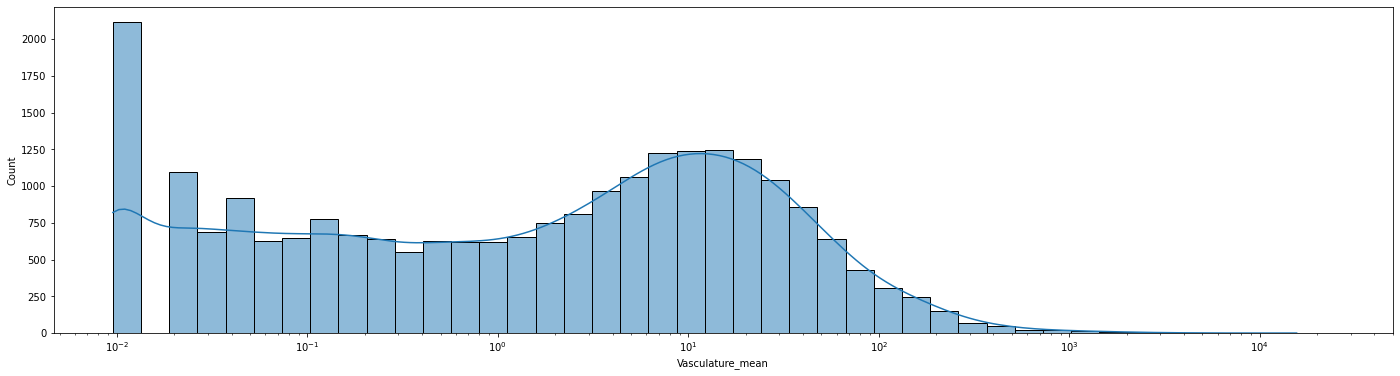

In [36]:
df=metacell_df[metacell_df['Vasculature_mean']>0]
fig, ax = plt.subplots(figsize=(24,6))
ax.set(xscale="log")
sns.histplot(ax=ax,data=df,x='Vasculature_mean', kde=True)
plt.xlim([0, 50000])

[None]

<AxesSubplot:xlabel='Vasculature_mean', ylabel='Count'>

/var/folders/_g/l621c6655y96l4zm2nwpfyq00000gn/T/ipykernel_1815/3544093389.py:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 1])


(1.0970353223335487e-09, 1)

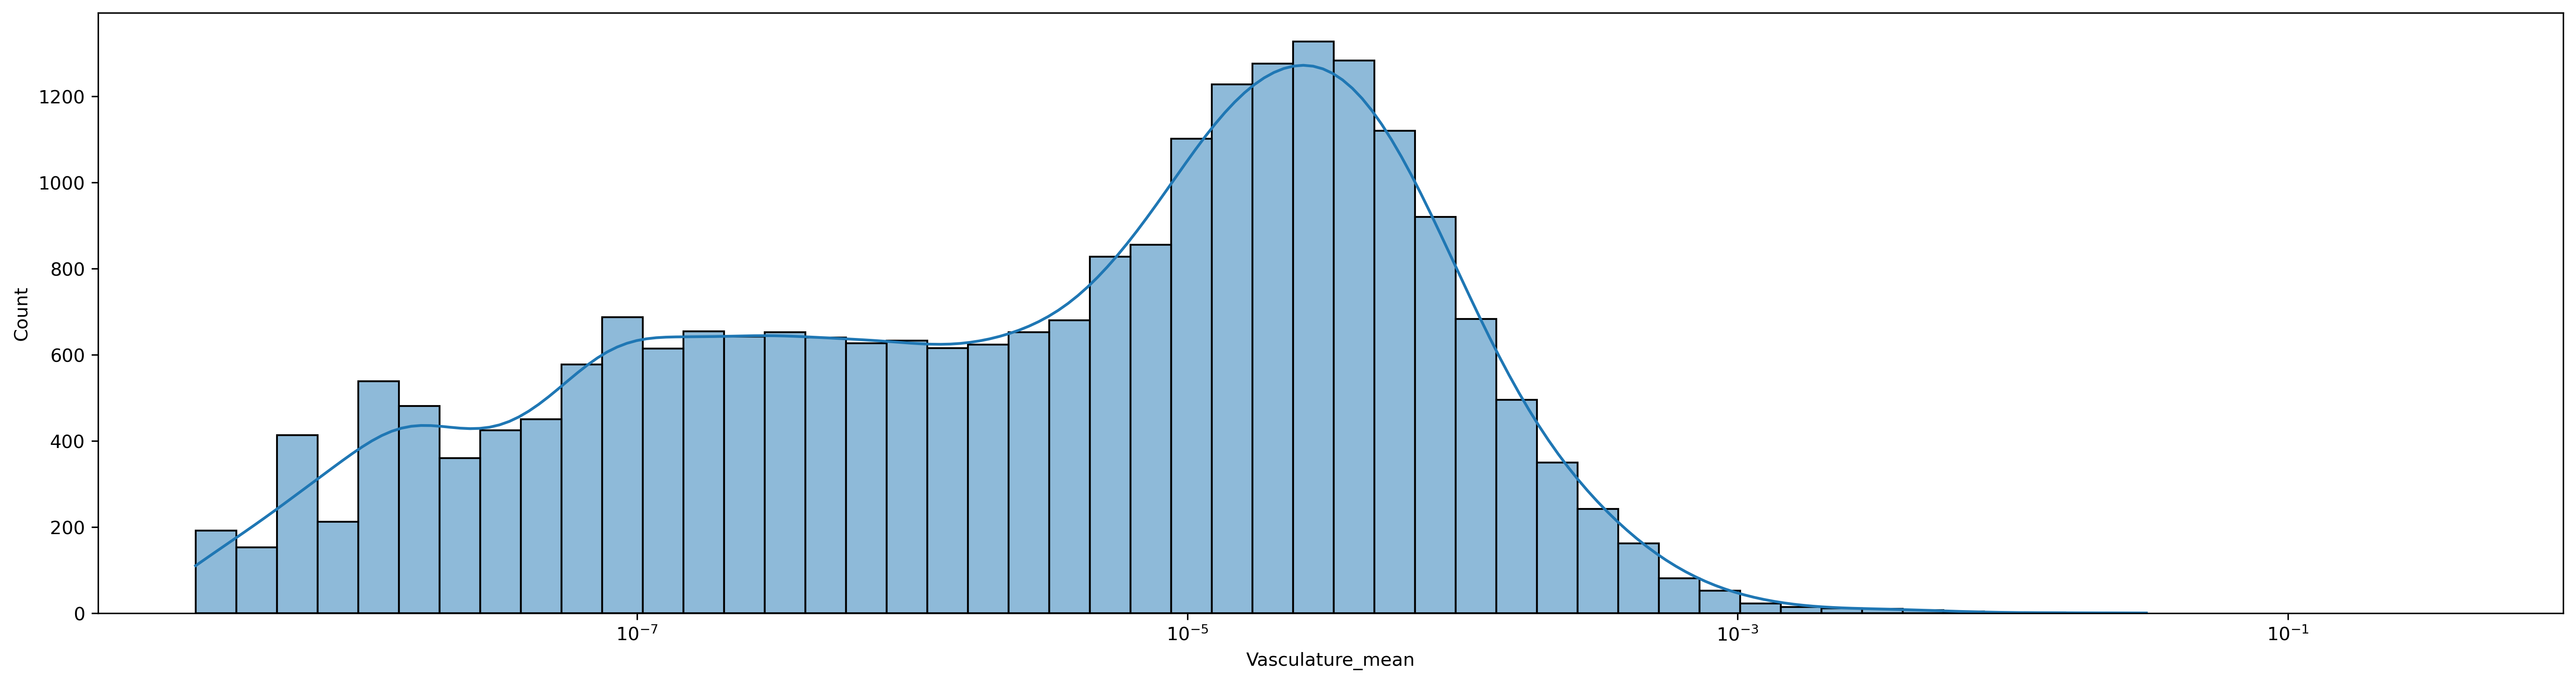

In [129]:
df=norm_exp_df[norm_exp_df['Vasculature_mean']>0]
fig, ax = plt.subplots(figsize=(24,6))
ax.set(xscale="log")
sns.histplot(ax=ax,data=df,x='Vasculature_mean', kde=True)
plt.xlim([0, 1])

/var/folders/_g/l621c6655y96l4zm2nwpfyq00000gn/T/ipykernel_14614/1820051918.py:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 50000])


(0.0035720831634785686, 50000)

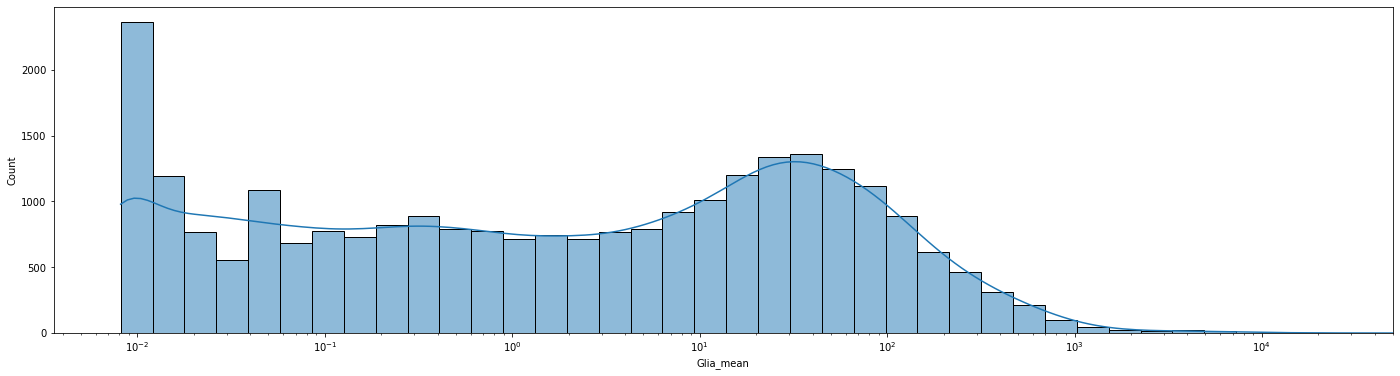

In [37]:
df=metacell_df[metacell_df['Glia_mean']>0]
fig, ax = plt.subplots(figsize=(24,6))
ax.set(xscale="log")
sns.histplot(ax=ax,data=df,x='Glia_mean', kde=True)
plt.xlim([0, 50000])

[None]

<AxesSubplot:xlabel='Glia_mean', ylabel='Count'>

/var/folders/_g/l621c6655y96l4zm2nwpfyq00000gn/T/ipykernel_1815/628547778.py:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 1])


(1.251648117974843e-10, 1)

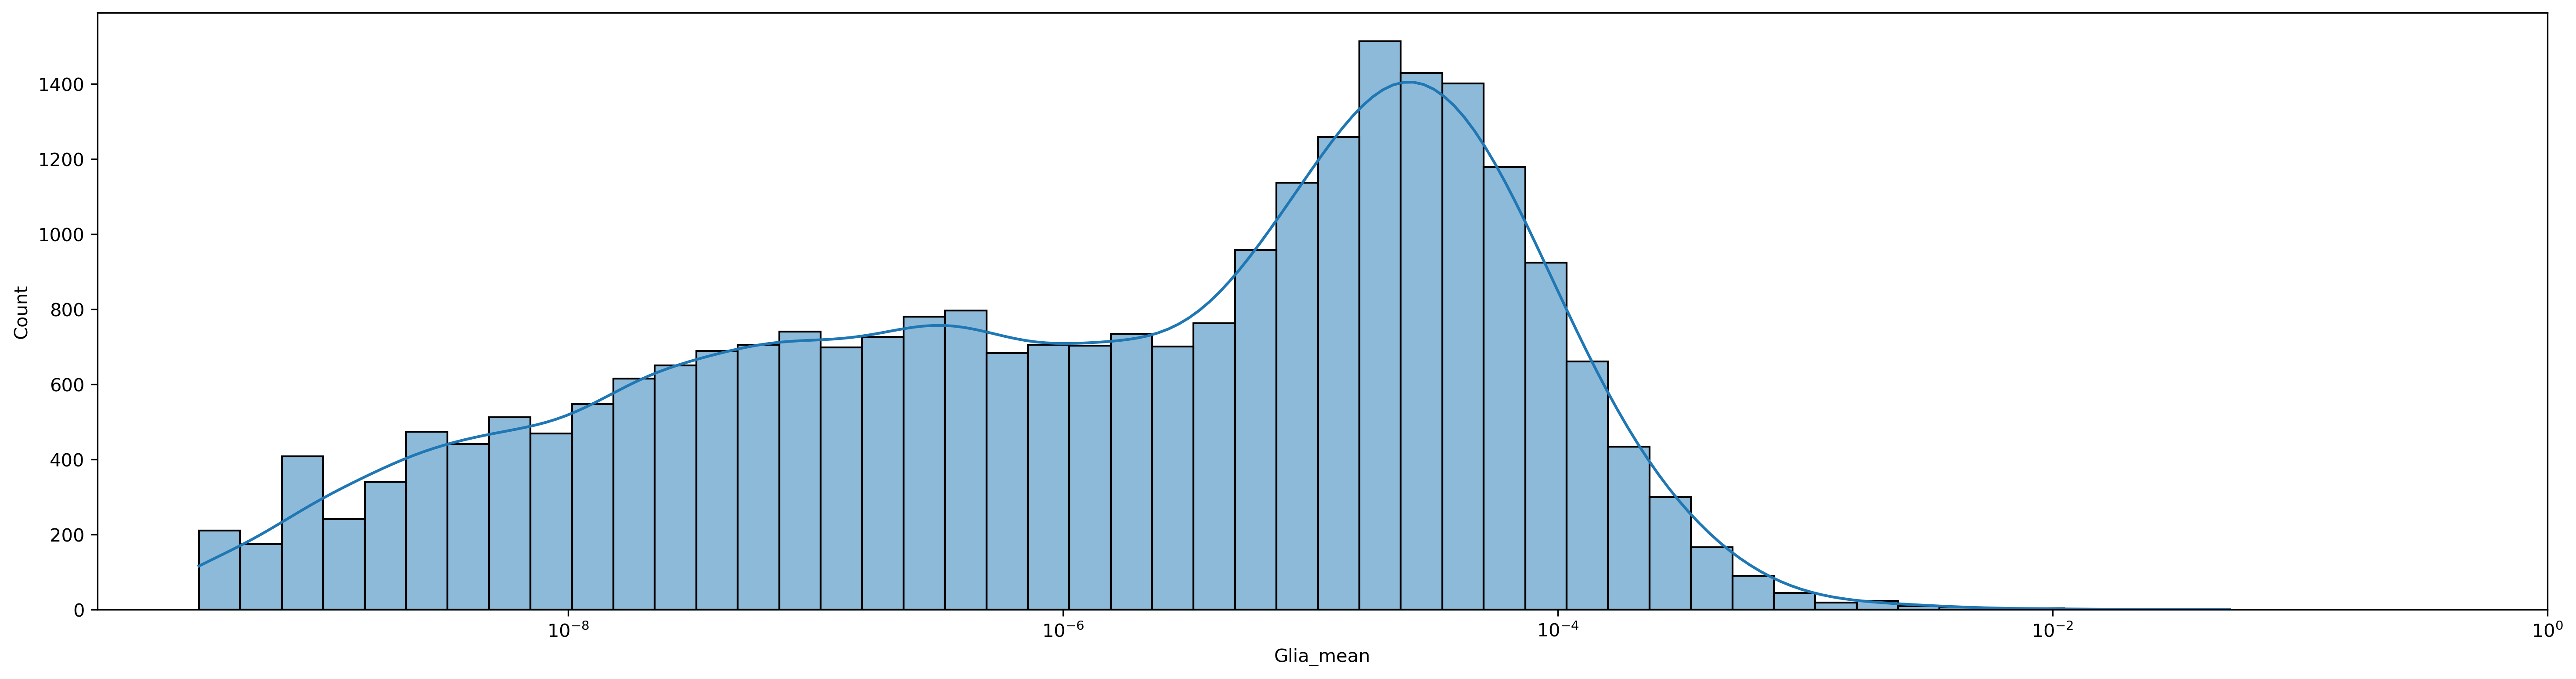

In [130]:
df=norm_exp_df[norm_exp_df['Glia_mean']>0]
fig, ax = plt.subplots(figsize=(24,6))
ax.set(xscale="log")
sns.histplot(ax=ax,data=df,x='Glia_mean', kde=True)
plt.xlim([0, 1])